# Chapter 4: Machine Learning state of the art
## Figure 4.17-19
Random Forests on the aging problem.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-paper')
plt.rc('text', usetex=False)

# 0. Load data
see `figure_4.5-13.ipynb`

In [37]:
# Load the data (drop NaNs)
df = pd.read_csv('../data/aging_data.csv', header=0, index_col=0).dropna()
columns = df.columns.drop(['age'])

# Learning data
dfx = df[columns]

# Learning labels
dfy = df['age']

# Convert gender [m/f] in [0,1]
dfx.loc[:, 'gender'] = dfx['gender'].apply(lambda x: int(x == 'f'))

# Preprocess data
from sklearn.preprocessing import StandardScaler

dfx.iloc[:,1:] = StandardScaler().fit_transform(dfx.values[:,1:])

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.33, random_state=42)

print('{} variables'.format(x_train.shape[1]))
print('{} training samples'.format(x_train.shape[0]))
print('{} test samples'.format(x_test.shape[0]))

12 variables
74 training samples
37 test samples


# 1. Fit `RandomForestRegressor`

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

max_n_estimators = 500

model = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=max_n_estimators), n_jobs=-1,
                     param_grid={'max_features': np.arange(3, x_train.shape[1])})
model.fit(x_train.values, y_train.values)

y_pred = model.predict(x_test)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
evs = metrics.explained_variance_score(y_test, y_pred)


print('max_features: {:2.5f}'.format(model.best_estimator_.max_features))
print('EVS: {:2.5f}'.format(evs))
print('R2: {:2.3f}'.format(r2))
print('MAE: {:2.3f}'.format(mae))

max_features: 4.00000
EVS: 0.88004
R2: 0.871
MAE: 6.372


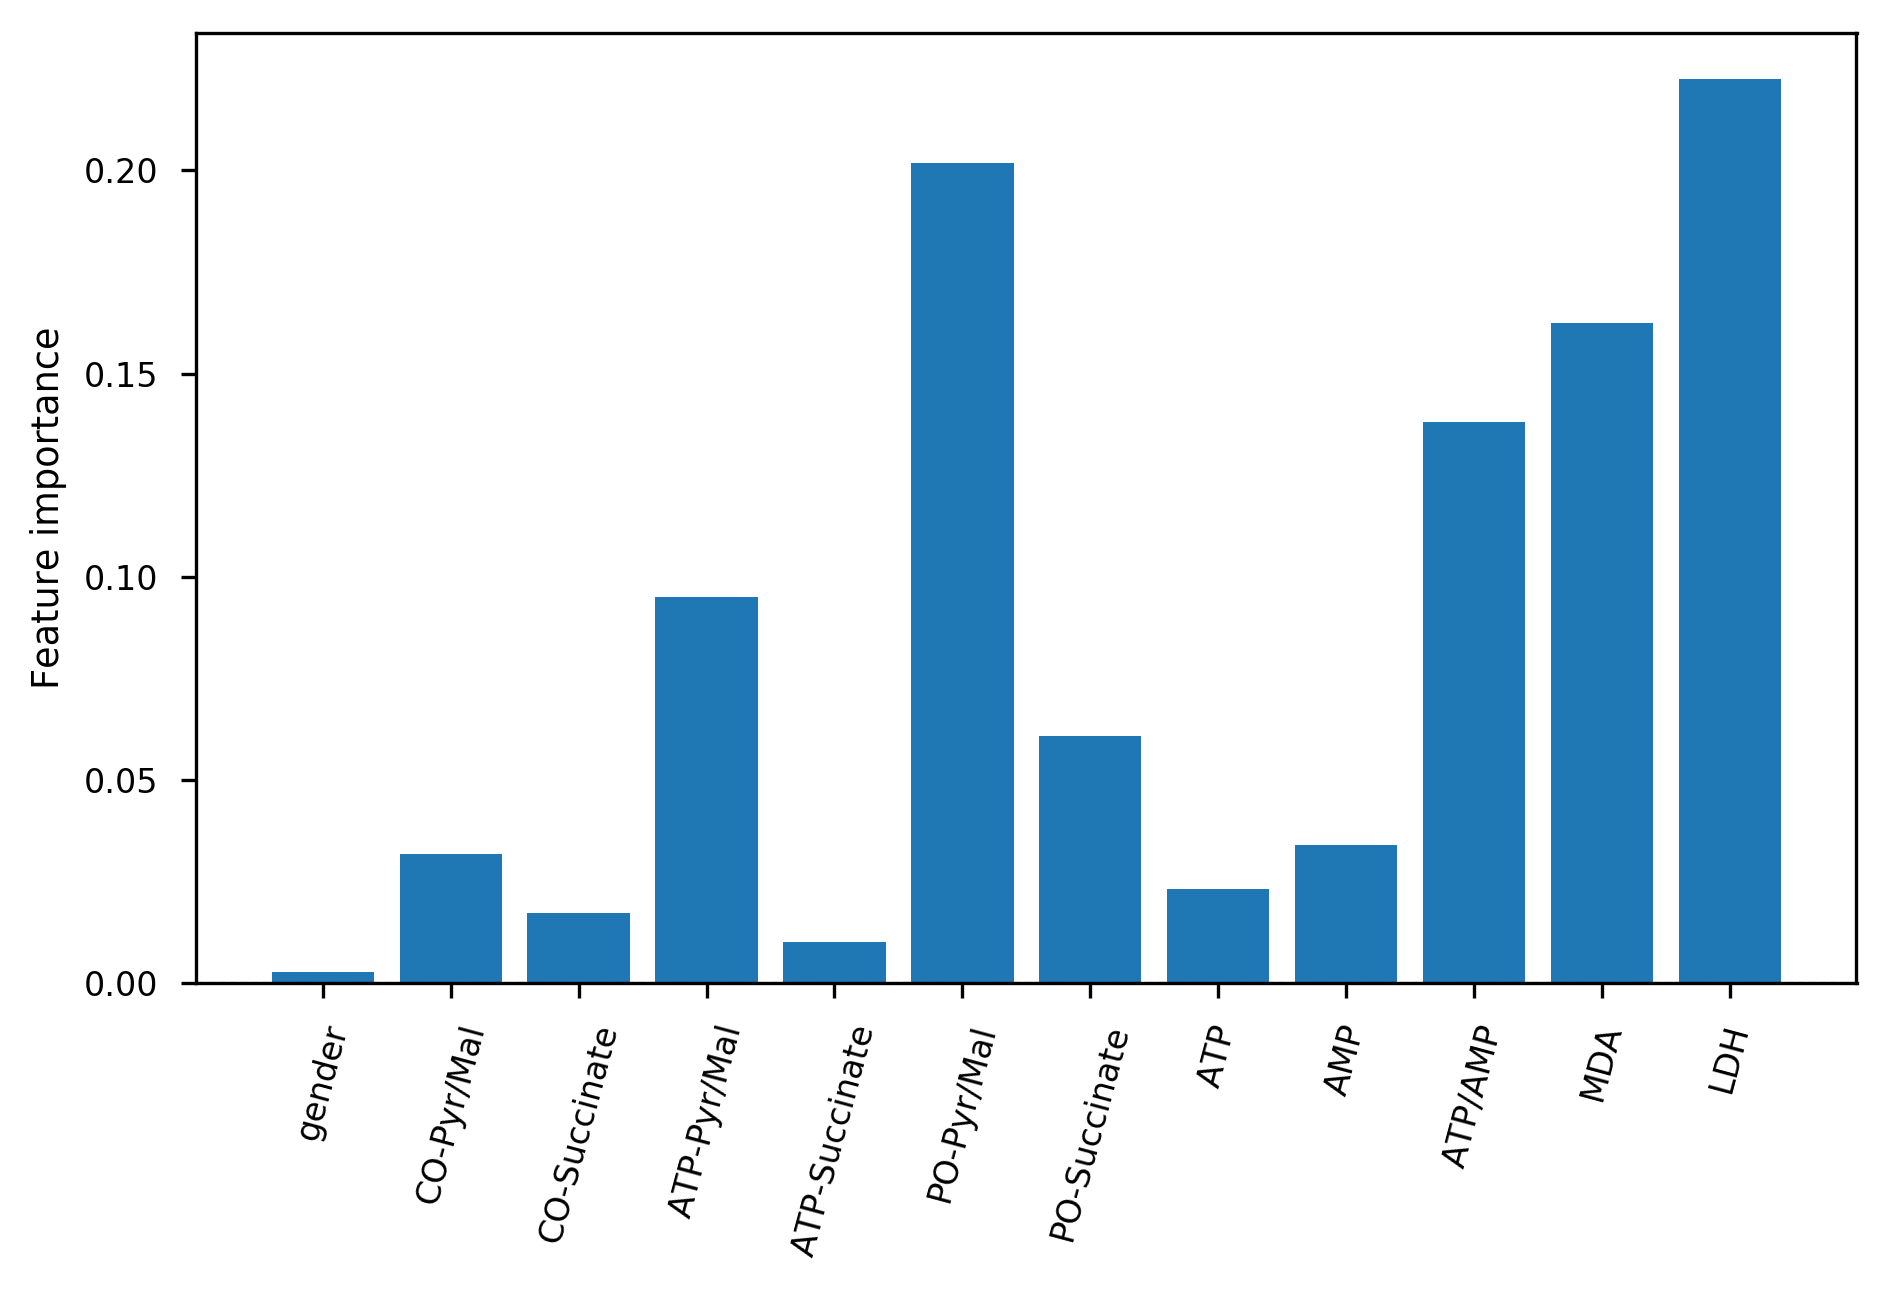

In [39]:
plt.figure(dpi=300)

xaxis = np.arange(x_train.shape[1])
plt.bar(xaxis, model.best_estimator_.feature_importances_, color='C0') # positive coefs
plt.axhline(color='k', linewidth=0.5, linestyle='dashed')
plt.ylabel('Feature importance')
plt.xticks(xaxis, dfx.columns, rotation=75)

plt.tight_layout()
plt.savefig('../images/rf_feature_importance.png', bbox_inches='tight');

# 2. Fit increasingly large forests
Investigating on the effect of `n_estimators`.

In [40]:
n_estimators_range = np.arange(1, max_n_estimators)

rf = RandomForestRegressor(warm_start=True, max_features=4, random_state=0)

test_MAE = []
test_EVS = []
train_MAE = []
train_EVS = []

for n_estimators in n_estimators_range:
    rf.set_params(n_estimators=n_estimators)
    rf.fit(x_train.values, y_train.values)
    y_pred = rf.predict(x_test.values)
    y_pred_tr = rf.predict(x_train.values)
    
    test_MAE.append(metrics.mean_absolute_error(y_test, y_pred))
    test_EVS.append(metrics.explained_variance_score(y_test, y_pred))
    
    train_MAE.append(metrics.mean_absolute_error(y_train, y_pred_tr))
    train_EVS.append(metrics.explained_variance_score(y_train, y_pred_tr))

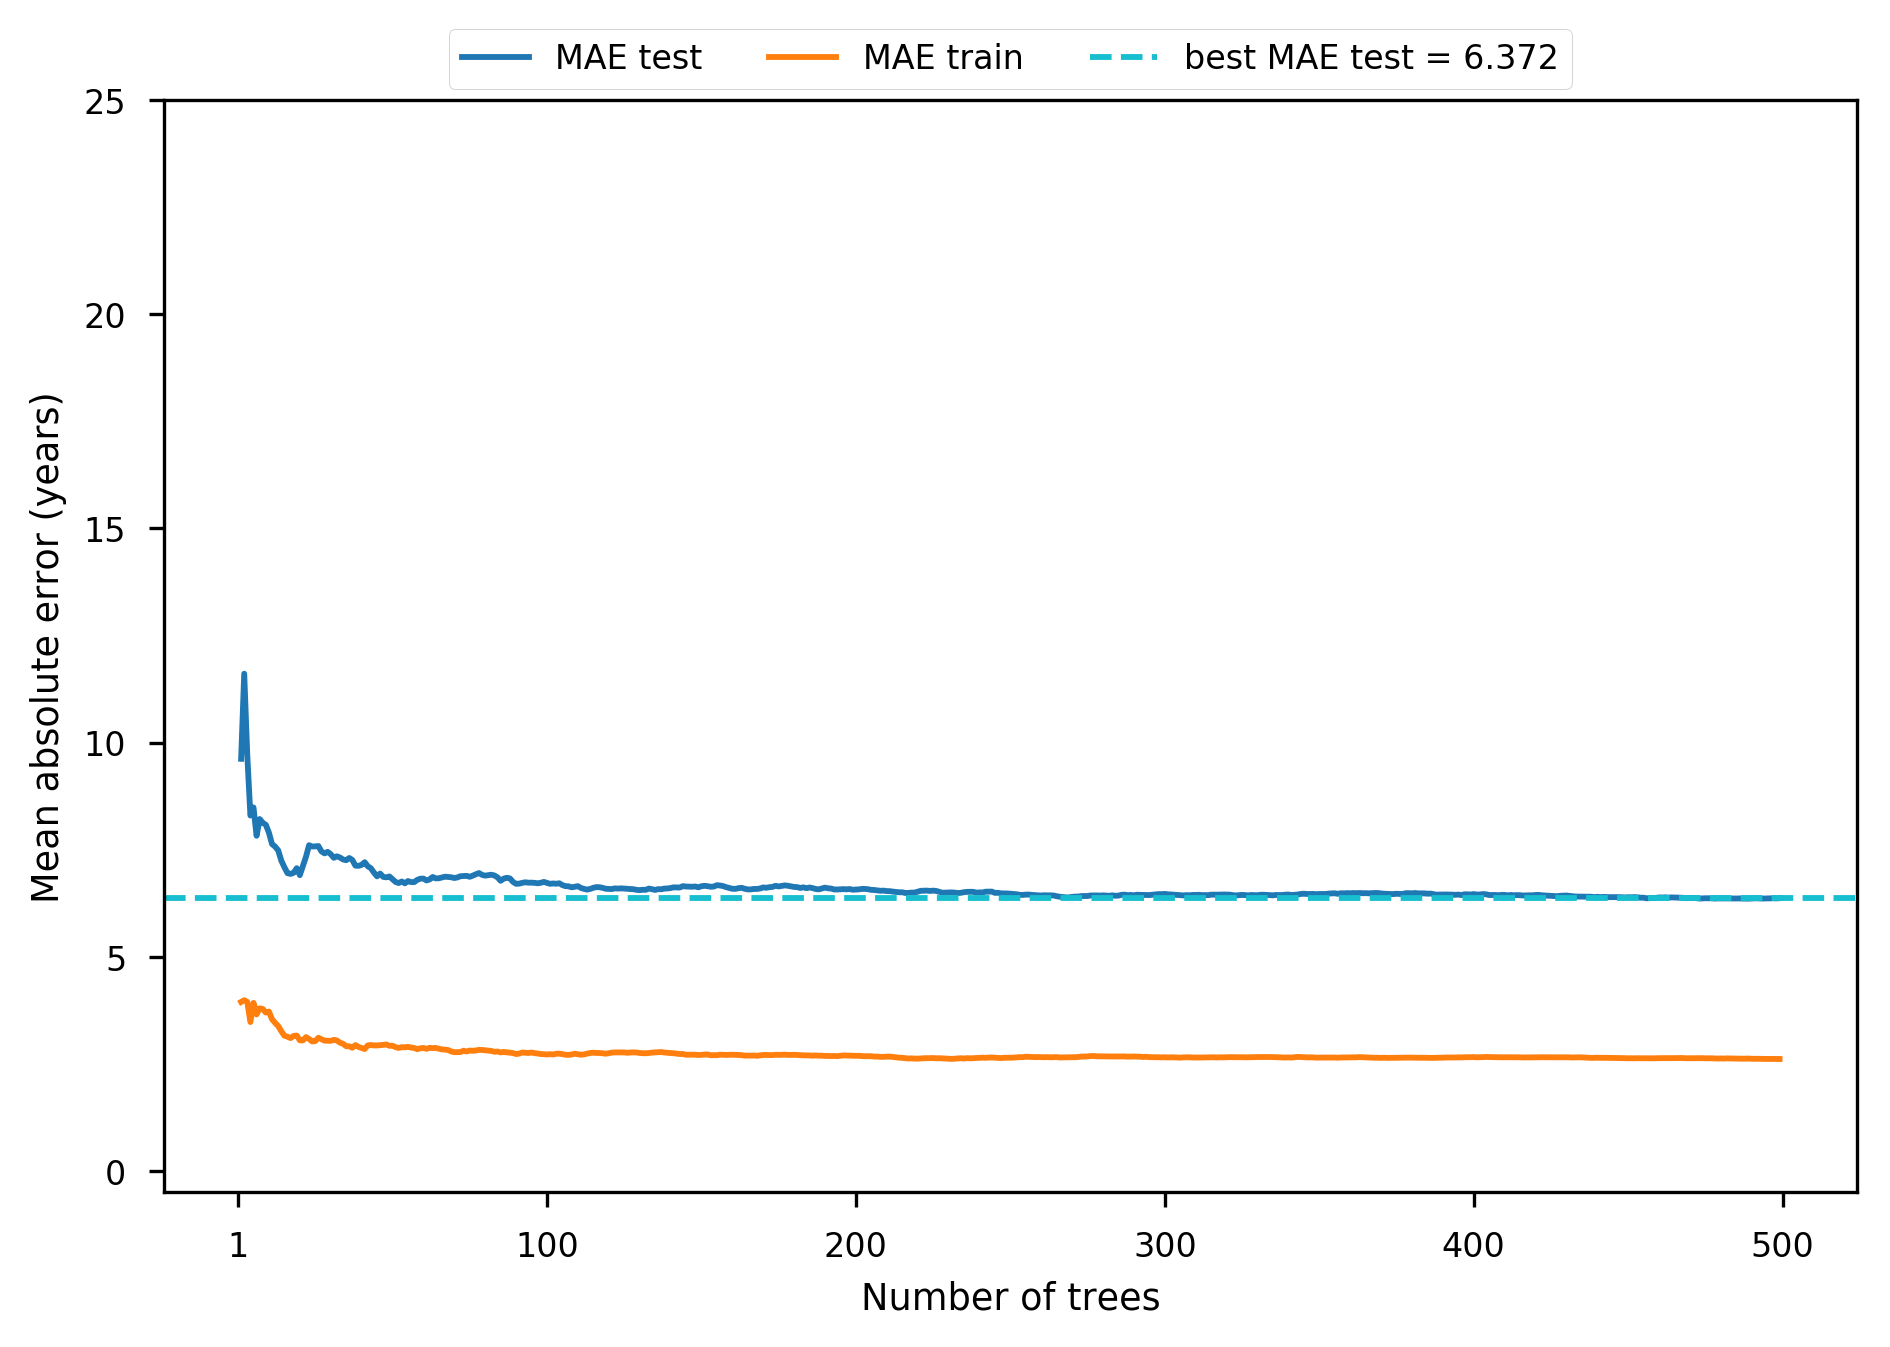

In [45]:
plt.figure(dpi=300)

plt.plot(n_estimators_range, test_MAE, color='C0', label='MAE test')
plt.plot(n_estimators_range, train_MAE, color='C1', label='MAE train')
plt.axhline(mae, linestyle='dashed', color='C9', label='best MAE test = {:2.3f}'.format(mae))

plt.xticks([0, 100, 200, 300, 400, 500], [1, 100, 200, 300, 400, 500])
plt.xlabel('Number of trees')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
          ncol=3, fancybox=True, shadow=False)
plt.ylabel('Mean absolute error (years)')

plt.ylim([-0.5, 25])

plt.tight_layout()
plt.savefig('../images/rf_increasing_MAE.png', bbox_inches='tight');

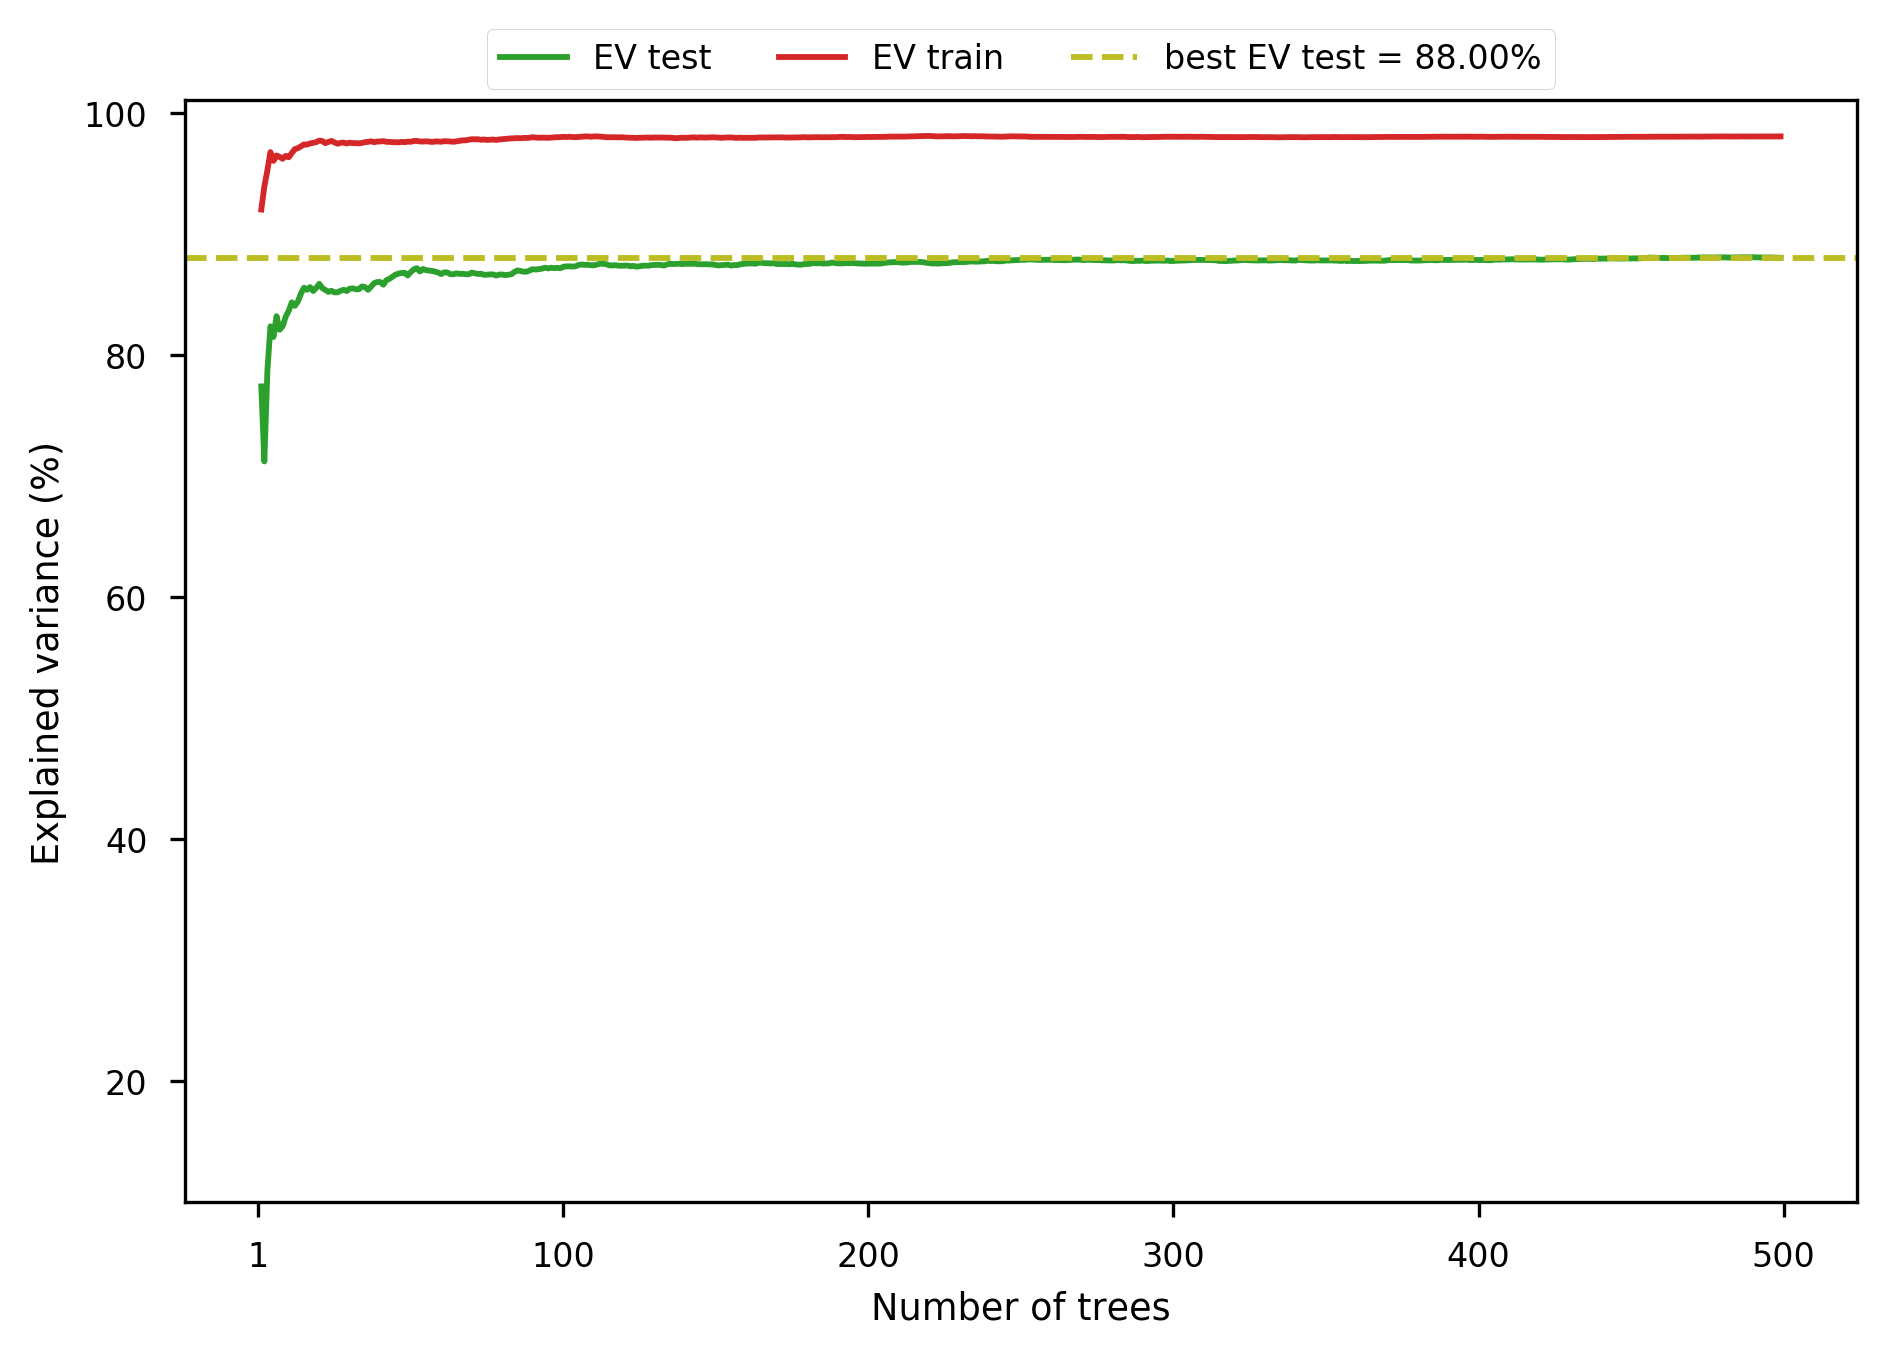

In [46]:
plt.figure(dpi=300)

plt.plot(n_estimators_range, 100*np.array(test_EVS), color='C2', label='EV test')
plt.plot(n_estimators_range, 100*np.array(train_EVS), color='C3', label='EV train')
plt.axhline(100*evs, linestyle='dashed', color='C8', label='best EV test = {:2.2f}%'.format(100*evs))

plt.xticks([0, 100, 200, 300, 400, 500], [1, 100, 200, 300, 400, 500])
plt.xlabel('Number of trees')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
          ncol=3, fancybox=True, shadow=False)
plt.ylim([10, 101])
plt.ylabel('Explained variance (%)')

plt.tight_layout()
plt.savefig('../images/rf_increasing_EV.png', bbox_inches='tight');